In [2]:
from utils.streamline_to_surface_utils import *
from utils.surface_label_utils import *
import os.path as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
subjects_dir = "/home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer"
subjects_list = ["subj01", "subj02", "subj03", "subj04", "subj05", "subj06", "subj07", "subj08"]
#subjects_list = ["subj01", "subj02"]
hemis = ["lh", "rh"]
runs = ["run1", "run2"]
floc_faces_labels = {1: "OFA", 2: "FFA1", 3: "FFA2"}

In [4]:
# Create 9 dataframes that contain endpoint proportions by eccentricity about all subjects/run (each row):
    # Separated by hemisphere
    # OFA -> IPS0, OFA -> IPS1, OFA -> IPS0/1
    # FFA1 -> ...
    # FFA2 -> ...
    
lhOFAtoIPS0or1 = pd.DataFrame(data=np.arange(0, 9, 0.5), columns=["Eccentricity"])
lhOFAtoIPS0 = pd.DataFrame(data=np.arange(0, 9, 0.5), columns=["Eccentricity"])
lhOFAtoIPS1 = pd.DataFrame(data=np.arange(0, 9, 0.5), columns=["Eccentricity"])

lhFFA1toIPS0or1 = pd.DataFrame(data=np.arange(0, 9, 0.5), columns=["Eccentricity"])
lhFFA1toIPS0 = pd.DataFrame(data=np.arange(0, 9, 0.5), columns=["Eccentricity"])
lhFFA1toIPS1 = pd.DataFrame(data=np.arange(0, 9, 0.5), columns=["Eccentricity"])

lhFFA2toIPS0or1 = pd.DataFrame(data=np.arange(0, 9, 0.5), columns=["Eccentricity"])
lhFFA2toIPS0 = pd.DataFrame(data=np.arange(0, 9, 0.5), columns=["Eccentricity"])
lhFFA2toIPS1 = pd.DataFrame(data=np.arange(0, 9, 0.5), columns=["Eccentricity"])

rhOFAtoIPS0or1 = pd.DataFrame(data=np.arange(0, 9, 0.5), columns=["Eccentricity"])
rhOFAtoIPS0 = pd.DataFrame(data=np.arange(0, 9, 0.5), columns=["Eccentricity"])
rhOFAtoIPS1 = pd.DataFrame(data=np.arange(0, 9, 0.5), columns=["Eccentricity"])

rhFFA1toIPS0or1 = pd.DataFrame(data=np.arange(0, 9, 0.5), columns=["Eccentricity"])
rhFFA1toIPS0 = pd.DataFrame(data=np.arange(0, 9, 0.5), columns=["Eccentricity"])
rhFFA1toIPS1 = pd.DataFrame(data=np.arange(0, 9, 0.5), columns=["Eccentricity"])

rhFFA2toIPS0or1 = pd.DataFrame(data=np.arange(0, 9, 0.5), columns=["Eccentricity"])
rhFFA2toIPS0 = pd.DataFrame(data=np.arange(0, 9, 0.5), columns=["Eccentricity"])
rhFFA2toIPS1 = pd.DataFrame(data=np.arange(0, 9, 0.5), columns=["Eccentricity"])

In [5]:
### Need to develop method to store proportion by eccentricity 
# Subj/run/hemi -> 0-1 1-2 2-3 3-4 4-5 5-6+ or by 0.5s?

# 1 table for each VTC ROI: FFA1 to IPS0/1; FFA2 to IPS0/1; OFA to IPS0/1
for subj in subjects_list:
    subj_dir = op.join(subjects_dir, subj)
    for hemi in hemis:
        for run in runs:
            floc_faces_path = op.join(subj_dir, "fyz", "anatomy", f"{hemi}-rois", "all", "floc-faces", "t>0", f"{hemi}.floc-faces.subsetted.mgz")
            available_ROIs, available_ROINums = available_floc_rois(floc_faces_path)
            for start in available_ROINums:   
                prf_label = op.join(subjects_dir, subj, "label", hemi + ".prfeccentricity.smoothed.mgz") # non smoothed is just without .smoothed

                endpoints_to_IPS0 = op.join(subjects_dir, subj, "fyz", run, hemi, "all", "t>3", "track-merged", 
                        f"node{int(start)}-18.endpoints.cleaned_withManualIPS.mgz") # could also be .IPS-intersected.mgz
                endpoints_to_IPS1 = op.join(subjects_dir, subj, "fyz", run, hemi, "all", "t>3", "track-merged", 
                                        f"node{int(start)}-19.endpoints.cleaned_withManualIPS.mgz") # could also be .IPS-intersected.mgz
                
                concat_surflabels(endpoints_to_IPS0, endpoints_to_IPS1, write_file=True, 
                                out_path=op.join(subjects_dir, subj, "fyz", run, hemi, "all", "t>3", "track-merged"), 
                                change_label="withIPS1")
                endpoints_to_IPS0or1 = op.join(subjects_dir, subj, "fyz", run, hemi, "all", "t>3", "track-merged", 
                                        f"node{int(start)}-18.endpoints.IPS-intersected.withIPS1.mgz")
                
                startToIPS0or1, startToIPS0or1Count = label_endpoints_with_pRF_property(prf_label, endpoints_to_IPS0or1)
                startToIPS0, startToIPS0Count = label_endpoints_with_pRF_property(prf_label, endpoints_to_IPS0)
                startToIPS1, startToIPS1Count = label_endpoints_with_pRF_property(prf_label, endpoints_to_IPS1)

                for items in [[startToIPS0or1, startToIPS0or1Count, "IPS0or1"], [startToIPS0, startToIPS0Count, "IPS0"], [startToIPS1, startToIPS1Count, "IPS1"]]:
                    propStreamlinesSubj = f"propStreamlines{subj}{run}"
                    df = pd.DataFrame(items[0], columns=["Eccentricity", propStreamlinesSubj])
                    
                    dfwithEndpoints = df[df[propStreamlinesSubj] > 0]
                    dfReasonable = dfwithEndpoints[dfwithEndpoints["Eccentricity"] < 8.75] # WHAT SHOULD BE THRESH??? - 12.25 because rounding to nearest 0.5 
                    dfReasonable = (dfReasonable*2).round()/2 # rounding to neatest 0.5
                    dfReasonable = dfReasonable.groupby("Eccentricity").sum().reset_index()
                    dfReasonable[propStreamlinesSubj] = dfReasonable[propStreamlinesSubj] / items[1] # puts everything into proportions
                    
                    # Selectively merge with correct dataframe
                    vars()[f"{hemi}{floc_faces_labels[int(start)]}to{items[2]}"] = vars()[f"{hemi}{floc_faces_labels[int(start)]}to{items[2]}"].merge(dfReasonable, on="Eccentricity", how="outer")
                    

Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj01/fyz/run1/lh/all/t>3/track-merged/node1-18.endpoints.cleaned_withManualIPS.withIPS1.mgz
Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj01/fyz/run1/lh/all/t>3/track-merged/node2-18.endpoints.cleaned_withManualIPS.withIPS1.mgz
Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj01/fyz/run2/lh/all/t>3/track-merged/node1-18.endpoints.cleaned_withManualIPS.withIPS1.mgz
Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj01/fyz/run2/lh/all/t>3/track-merged/node2-18.endpoints.cleaned_withManualIPS.withIPS1.mgz
Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj01/fyz/run1/rh/all/t>3/track-merged/node1-18.endpoints.cleaned_withManualIPS.withIPS1.mgz
Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj01/fyz/run1/rh/all/t>3/track-merged/node2-18.endpoints.cleaned_withManualIPS.withIPS1.mgz
Writing to: /hom

Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj05/fyz/run2/lh/all/t>3/track-merged/node2-18.endpoints.cleaned_withManualIPS.withIPS1.mgz
Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj05/fyz/run2/lh/all/t>3/track-merged/node3-18.endpoints.cleaned_withManualIPS.withIPS1.mgz
Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj05/fyz/run1/rh/all/t>3/track-merged/node1-18.endpoints.cleaned_withManualIPS.withIPS1.mgz
Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj05/fyz/run1/rh/all/t>3/track-merged/node2-18.endpoints.cleaned_withManualIPS.withIPS1.mgz
Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj05/fyz/run1/rh/all/t>3/track-merged/node3-18.endpoints.cleaned_withManualIPS.withIPS1.mgz
Writing to: /home/naxos2-raid25/ahmad262/IPS-VTC-fWMT/data/freesurfer/subj05/fyz/run2/rh/all/t>3/track-merged/node1-18.endpoints.cleaned_withManualIPS.withIPS1.mgz
Writing to: /hom

In [108]:
df = lhOFAtoIPS0or1
transpose = df.transpose()
transpose = transpose.rename(columns=transpose.iloc[0])[1:]
#transpose = transpose.drop(["propStreamlinessubj07run1", "propStreamlinessubj07run2"])

In [109]:
a = transpose.describe()
means = a.loc['mean'].values.tolist()
stdevs = a.loc['std'].values.tolist()
counts = a.loc['count'].values.tolist()
index = np.arange(len(transpose.columns))

CI = []
for i in range(len(means)):
    CIval = 1.96*stdevs[i]/(counts[i]**(0.5))
    CI.append(CIval)

<Figure size 640x480 with 0 Axes>

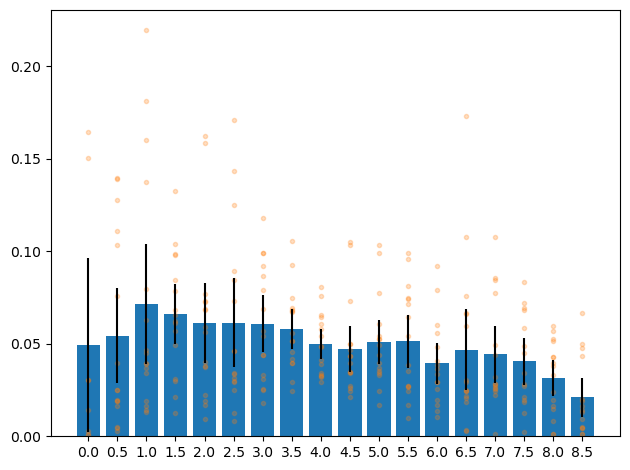

In [110]:
plt.figure()
fig, ax = plt.subplots()
ax.set_xticks(index)
ax.set_xticklabels(transpose.columns)

plt.bar(index, means, yerr=CI)
plt.tight_layout()
plt.scatter(transpose.melt()["variable"]*2, transpose.melt()["value"], marker=".", alpha=0.25)
plt.show()

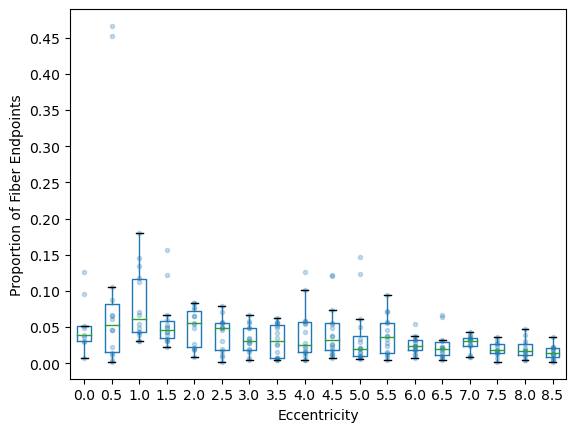

In [107]:
transpose.boxplot(grid=False, showfliers=False)
plt.xlabel("Eccentricity")
plt.ylabel("Proportion of Fiber Endpoints")
plt.yticks(np.arange(0, 0.5, 0.05))
plt.scatter(transpose.melt()["variable"]*2+1, transpose.melt()["value"], marker=".", alpha=0.25)
plt.show()

In [9]:
## DUE TO LOW IPS2/3 variance explained by pRF model, we constrain our analysis to IPS0/1 ##

# FFA1 vs FFA2 vs OFA to IPS0/1
subj = "subj02"
run = "run1"
hemi = "rh"
start = 2 # iterate through 1,2,3


prf_label = op.join(subjects_dir, subj, "label", hemi + ".prfeccentricity.mgz") # use smoothed eccentricity map
endpoints_to_IPS0 = op.join(subjects_dir, subj, "fyz", run, hemi, "all", "t>3", "track-merged", 
                          f"node{start}-18.endpoints.IPS-intersected.mgz")
endpoints_to_IPS1 = op.join(subjects_dir, subj, "fyz", run, hemi, "all", "t>3", "track-merged", 
                          f"node{start}-19.endpoints.IPS-intersected.mgz")

concat_surflabels(endpoints_to_IPS0, endpoints_to_IPS1, write_file=True, 
                  out_path=op.join(subjects_dir, subj, "fyz", run, hemi, "all", "t>3", "track-merged"), 
                  change_label="withIPS1")
endpoints_path = op.join(subjects_dir, subj, "fyz", run, hemi, "all", "t>3", "track-merged", 
                         f"node{start}-18.endpoints.IPS-intersected.withIPS1.mgz")


out = label_endpoints_with_pRF_property(prf_label, endpoints_path)

Writing to: /Applications/freesurfer/7.3.2/subjects/subj02/fyz/run1/rh/all/t>3/track-merged/node2-18.endpoints.IPS-intersected.withIPS1.mgz


In [10]:
df = pd.DataFrame(out[0], columns=["Eccentricity", "NumberStreamlines"])

dfwithEndpoints = df[df["NumberStreamlines"] > 0]

dfReasonable = dfwithEndpoints[dfwithEndpoints["Eccentricity"] < 6.25] # 6.25 because we are rounding to nearest half
# Rounding to nearest 0.5
dfReasonable = (dfReasonable*2).round()/2
dfReasonable = dfReasonable.groupby("Eccentricity").sum().reset_index()
dfReasonable["NumberStreamlines"] = dfReasonable["NumberStreamlines"] / out[1]

#print(dfReasonable)
#plt.bar(dfReasonable["Eccentricity"], dfReasonable["NumberStreamlines"])

In [68]:
df2 = pd.DataFrame(out[0], columns=["Eccentricity", "NumberStreamlinesRun2"])

df2withEndpoints = df2[df2["NumberStreamlinesRun2"] > 0]

df2Reasonable = df2withEndpoints[df2withEndpoints["Eccentricity"] < 6.25]
# Rounding to nearest 0.5
df2Reasonable = (df2Reasonable*2).round()/2
df2Reasonable = df2Reasonable.groupby("Eccentricity").sum().reset_index()
dfReasonable["NumberStreamlines"] = dfReasonable["NumberStreamlines"] / out[1]
df2Reasonable

,Eccentricity,NumberStreamlinesRun2
0,0.0,88.0
1,0.5,78.0
2,1.0,39.0
3,1.5,25.0
4,2.0,32.0
5,2.5,31.0
6,3.0,48.0
7,3.5,110.0
8,4.0,98.0
9,4.5,186.0


In [81]:
dfToPlot = dfReasonable.merge(df2Reasonable, on="Eccentricity")

<BarContainer object of 13 artists>

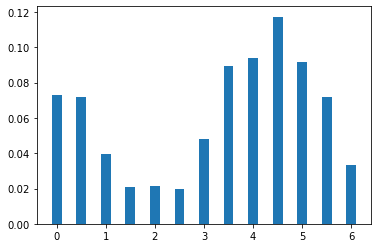

In [82]:
plt.bar(dfToPlot["Eccentricity"], dfToPlot["NumberStreamlines"], width=0.20)

In [11]:
vars()["dfReasonable"]
dfReasonable

,Eccentricity,NumberStreamlines
0,0.0,0.072727
1,0.5,0.071901
2,1.0,0.039669
3,1.5,0.020661
4,2.0,0.021488
5,2.5,0.019835
6,3.0,0.047934
7,3.5,0.089256
8,4.0,0.094215
9,4.5,0.117355
